In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statistics
import pickle
import glob
from astropy.io import fits
import warnings
warnings.filterwarnings("ignore")
from astropy.visualization import simple_norm
import matplotlib.patches as patches

### personally developed pipeline scripts
import wfc3_extract
import mjd_bjd
import wfc3_systematics
import bat_model
import wfc3_mcmc
import wfc3_spec_trace
import binning
import wfc3_extract_spec

### set-up graphs for publication
import matplotlib as mpl
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['font.size'] = 18
mpl.rcParams['axes.linewidth'] = 6
plt.rcParams['font.size'] = '18'

# 1) WLC Analysis

## 1.1)Data Reduction

In [2]:
#fpath='/Users/Trevor/Pythoncode/HST/WASP79/'
fpath = '/home/trevor/OneDrive/Coding/HST/WASP79/'

In [3]:
### 1) to run extraction script for first time
'''
MJD_UTC, flux, flux_err, raDeg, decDeg, scidata_0, scidata, xybox = wfc3_extract.wfc3_extract()
BJD_TDB_f = mjd_bjd.mjd_bjd(MJD_UTC, flux, flux_err, raDeg, decDeg)
'''
### 2) if extraction has been completed and saved as file already and need MJD
fileObject = open(fpath+'W79_data/wlc_extract_out', 'rb')
MJD_UTC, flux, flux_err, raDeg, decDeg, scidata_0, scidata, xybox = pickle.load(fileObject)
fileObject.close()

fileObject = open(fpath+'W79_data/BJD_TDB', 'rb')
BJD_TDB_f, flux, flux_err = pickle.load(fileObject)
fileObject.close()
#'''

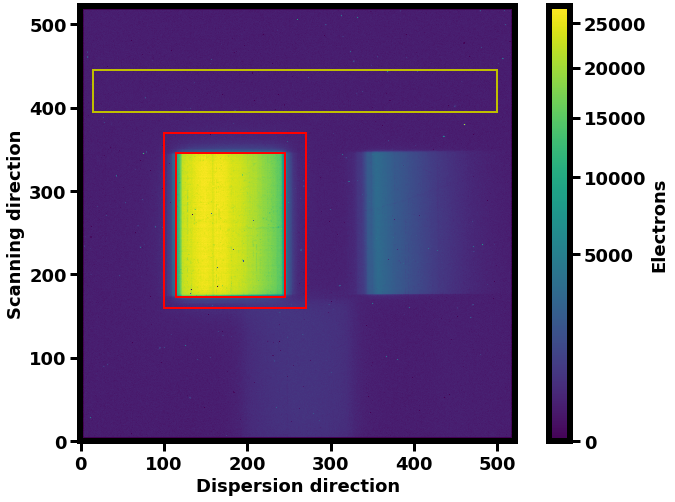

In [4]:
###View NDR of first image of first visit

# Create an ImageNormalize object
norm = simple_norm(scidata_0, 'sqrt', min_cut=0)

# Display the image
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(scidata_0, origin='lower', norm=norm)

#First order spectra search
rect1 = patches.Rectangle((xybox[0],xybox[2]),(xybox[1]-xybox[0]),(xybox[3]-xybox[2]), 
                          fill=False, ec='r', linewidth=2)
rect2 = patches.Rectangle((100,160),(170),(210), fill=False, ec='r', linewidth=2)
#Background region
rect3 = patches.Rectangle((15,xybox[3]+50),(485),(50), fill=False, ec='y', linewidth=2)

ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)

fig.colorbar(im, label='Electrons')
ax.set_xlabel('Dispersion direction', fontsize=18)
ax.set_ylabel('Scanning direction', fontsize=18)
fig.show()

Start of observation in BJD(TDB): 2457707.704777927


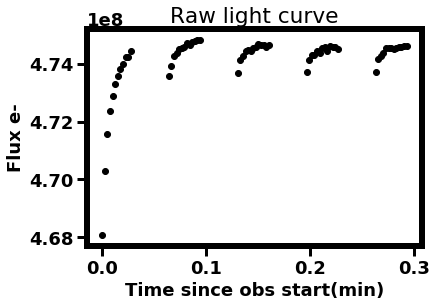

In [5]:
obs_start_BJD = np.amin(BJD_TDB_f)
print('Start of observation in BJD(TDB):', obs_start_BJD)

tt = BJD_TDB_f-obs_start_BJD

plt.figure()
plt.errorbar(tt, flux, flux_err, fmt='o', color='k')
plt.title('Raw light curve')
plt.xlabel('Time since obs start(min)')
plt.ylabel('Flux e-')
plt.show()

In [6]:
print('Total exposures:', len(flux), len(BJD_TDB_f))
flux, ttt, flux_err, BJD_TDB_ff = wfc3_systematics.remove_first_orbit(
    flux, tt, flux_err, BJD_TDB_f)
print('Total exposures after removing first orbit:', len(flux), 
      len(BJD_TDB_ff))
flux, t, flux_err, BJD_TDB = wfc3_systematics.remove_first_exposures(
    flux, ttt, flux_err, BJD_TDB_ff)
print('Total exposures after removing first exposures:', len(flux), len(BJD_TDB))

Total exposures: 64 64
Total exposures after removing first orbit: 52 52
First exposures = [ 0 13 26 39]
Total exposures after removing first exposures: 48 48


In [7]:
#### Remove second exposure from second orbit
flux = np.delete(flux,0)
t = np.delete(t,0)
flux_err = np.delete(flux_err,0)
BJD_TDB = np.delete(BJD_TDB,0)
print('Total usable exposures:', len(flux), len(BJD_TDB))

Total usable exposures: 47 47


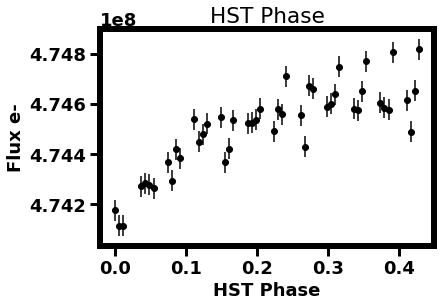

In [8]:
P_HST = 96.0/(24.0*60.0)    
HSTphase = (BJD_TDB)/P_HST
HSTphase = HSTphase-np.floor(HSTphase)
HSTphase = HSTphase-np.amin(HSTphase)

plt.figure()
plt.errorbar(HSTphase, flux, flux_err, fmt='o', color='k')
plt.title('HST Phase')
plt.xlabel('HST Phase')
plt.ylabel('Flux e-')
plt.show()

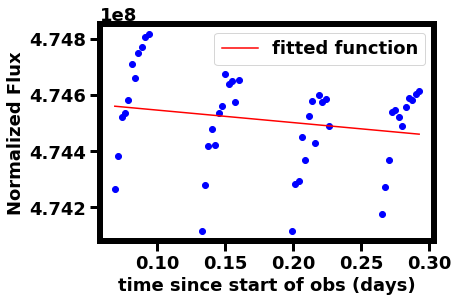

m = -444490.2907770872
b = 474590584.590352


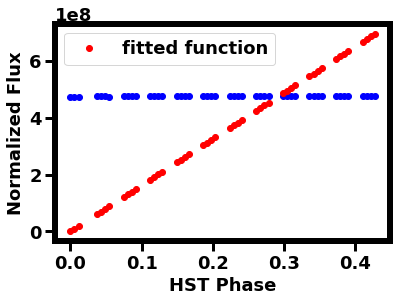

S = 101.00202008687297
phi = 100.98456232251326
C = 1624421708.901974


In [9]:
m, b = wfc3_systematics.guess_lin_coeffs(t, flux)
S, phi, C = wfc3_systematics.guess_hook_coeffs(HSTphase, flux)

## 1.2) Introduce BATMAN model

In [10]:
#specify orbital parameters and limb darkening
t0 = 2457706.0503976-obs_start_BJD 			#time of inferior conjunction in BJD(TDB)
per = 3.66239264			#orbital period
rp = 0.10675				#planet radius (in units of stellar radii)
a = 7.292					#semi-major axis (in units of stellar radii)
inc = 85.929				#orbital inclination (in degrees)
ecc = 0.					#eccentricity
w = 90.						#longitude of periastron (in degrees) 
u = [0.5012, 0.2630, -0.1034, -0.0301] 		 #limb darkening coefficients
limb_dark = "nonlinear"     #limb darkening model
transit_type = "secondary"  #transit type: primary (transit), seconday(eclipse)

#parameters specific for eclipse modeling include:
fp = 0.0002                 #planet-to-star flux ratio
t_secondary = 2457707.88159392-obs_start_BJD   #central eclipse time in BJD(TDB)

In [11]:
params, init_bat_model = bat_model.initialize_model(t, t0, per, rp, a, 
                            inc, ecc, w, u, limb_dark, transit_type, 
                            fp, t_secondary)

init_bat_lc = init_bat_model.light_curve(params)
plt.plot(t, init_bat_lc)
plt.show()

AttributeError: module 'batman' has no attribute 'TransitParams'

### 1.2.1) free t_secondary

In [12]:
###initial theta guesses
fixed_t_sec = False
if fixed_t_sec == True:
    theta_guess = np.zeros(6)
else:
    theta_guess = np.zeros(7)
    
theta_guess[0] = m    #linear coeff m
theta_guess[1] = b    #linear coeff b
theta_guess[2] = S    #hook coeff S
theta_guess[3] = phi  #hook coeff phi
theta_guess[4] = C    #hook coeff C
theta_guess[5] = fp
if fixed_t_sec == False:
    theta_guess[6] = t_secondary

fit_theta, fit_corr_bat_lc, fit_bat_lc, linearfit, hookfit = bat_model.fit_model(
    theta_guess, init_bat_model, params, t, HSTphase, flux, flux_err, 
    t_secondary, fixed_t_sec)

NameError: name 'init_bat_model' is not defined

In [ ]:
plt.figure()
plt.scatter(t, flux/linearfit/hookfit)
plt.xlabel('time since start of obs (days)')
plt.ylabel('Flux')
plt.ylim(0.9995,1.0005)
plt.title('Flux after removing Linear & Hook (free t)')
plt.show()

res = flux/linearfit/hookfit
#print(res)
print('Sum of the residuals =', sum(res))
SDNR = statistics.stdev(res)
print('SDNR =', SDNR)

for i in np.arange(len(flux_err)):
    flux_err[i] = flux[i]*SDNR

In [ ]:
res = bat_model.residuals(fit_theta, init_bat_model, params, t, HSTphase, flux, 
                flux_err, t_secondary, fixed_t_sec)

plt.figure()
plt.scatter(t, res)
plt.xlabel('time since start of obs (days)')
plt.ylabel('Residual')
plt.title('Updated residuals with SDNR correction')
plt.show()

chi2 = sum(res*res)
print('Chi-square=', chi2)

dof = len(flux)-len(fit_theta)
print('Deg of freedom=', dof)

rchi2 = chi2/dof
print('Reduced Chi-square=', rchi2)

fit_corrs = linearfit*hookfit

plt.figure()
plt.errorbar(t, flux, flux_err, fmt='o', color='b', label='obs')
plt.plot(t, fit_corr_bat_lc, 'ro',
         label='fitted function')
#plt.plot(BJD_TDB, mean_flux*fit_corrs, 'go', label = 'just corrections')
plt.xlabel('time since start of obs (days)')
plt.ylabel('Flux')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

#print(fit_theta)

### Fig 1 for paper

In [ ]:
norm_flux = flux/np.mean(flux)
n_m, n_b = wfc3_systematics.guess_lin_coeffs(t, norm_flux)
n_S, n_phi, n_C = wfc3_systematics.guess_hook_coeffs(HSTphase, norm_flux)
norm_lin_fit = wfc3_systematics.lin_trend(t, n_m, n_b)
norm_hook_fit = wfc3_systematics.hook_trend(HSTphase, n_S, n_phi, n_C)
norm_corr = norm_lin_fit*norm_hook_fit

In [ ]:
fig, axs = plt.subplots(4,1, sharex='col', gridspec_kw={'hspace':0.05}, 
                        figsize=(20,15))

for ax in axs:
    plt.xticks(weight='bold')
    plt.yticks(weight='bold')
    
### Raw light curve
r_wl = norm_flux
axs[0].plot(BJD_TDB, r_wl, 'ko')
axs[0].plot(BJD_TDB, fit_bat_lc, linewidth=5)
axs[0].set_ylabel('Relative Flux')
axs[0].set_title('Raw light curve', fontsize=20, fontweight='bold')
axs[0].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.4f'))

#raw residual
r_res = r_wl - fit_bat_lc

axs[1].plot(BJD_TDB, r_res*1e6, 'ko')
axs[1].set_xlabel('$\mathbf{BJD_{TDB}}$')
axs[1].set_ylabel('Raw Residuals (ppm)')
axs[1].set_gridspec_kw={'hspace':5}

### Corrected light curve
c_wl = norm_flux/norm_corr
axs[2].plot(BJD_TDB, c_wl, 'ko')
axs[2].plot(BJD_TDB, fit_bat_lc, linewidth=5)
axs[2].set_ylabel('Relative Flux', fontsize=14, fontweight='bold')
axs[2].set_title('Corrected light curve', fontsize=20, fontweight='bold')
axs[2].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.4f'))


### Residuals after corrections
c_res = c_wl-fit_bat_lc
axs[3].plot(BJD_TDB, c_res*1e6, 'ko', )
axs[3].set_xlabel('$\mathbf{BJD_{TDB}}$', fontsize=14)
axs[3].set_ylabel('Residuals (ppm)', fontsize=14, fontweight='bold')

## 1.3) MCMC

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Fri Sep 18 14:36:27 2020

@author: Trevor
"""
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import bat_model

def mcmc(theta, BJD_TDB, flux, flux_err, model, params, HSTphase, t_secondary, 
         fixed_t_sec, G_t, G_err, SDNR, P):
    ndim, nwalkers, nsteps = len(theta), 50, 10000 #6*len(theta) #3*len(theta) 
    sampler=emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(params, model,
                                        BJD_TDB, flux, flux_err, HSTphase,
                                        t_secondary, fixed_t_sec, G_t, G_err, P))
    #pos=[theta*(1.+1.e-2*np.random.randn(ndim)) for i in range(nwalkers)]
    pos=[theta*(1.+SDNR*np.random.randn(ndim)) for i in range(nwalkers)]
    if fixed_t_sec == False:
        for i in np.arange(len(pos)):
            pos[i][6] = theta[6] + (0.005*np.random.randn())
    sampler.run_mcmc(pos, nsteps, progress=True);

    #Burn in removal
    samples=sampler.chain[:,int(0.2*nsteps):,:].reshape((-1,ndim))
    #samples=sampler.chain[:,:,:].reshape((-1,ndim))

    if fixed_t_sec == False:
        m_mcmc, b_mcmc, S_mcmc, phi_mcmc, C_mcmc, fp_mcmc, t0_mcmc=map(
                lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
                zip(*np.percentile(samples, [16, 50, 84], axis=0)))
        fig = corner.corner(samples, labels = ['m', 'b', 'S', 'phi', 'C', 
                                               'fp', 't_secondary'])
        mcmc_params = [m_mcmc, b_mcmc, S_mcmc, phi_mcmc, C_mcmc, fp_mcmc, t0_mcmc]
        
    else:
        m_mcmc, b_mcmc, S_mcmc, phi_mcmc, C_mcmc, fp_mcmc =map(
                lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
                zip(*np.percentile(samples, [16, 50, 84], axis=0)))
    
        fig = corner.corner(samples, labels = ['m', 'b', 'S', 'phi', 'C', 
                                               'fp'])
        mcmc_params = [m_mcmc, b_mcmc, S_mcmc, phi_mcmc, C_mcmc, fp_mcmc]
    plt.show() 
    
    print('parameter', )
    print('m', m_mcmc)
    print('b', b_mcmc)
    print('S', S_mcmc)
    print('phi', phi_mcmc)
    print('C', C_mcmc)
    print('fp', fp_mcmc)
    if fixed_t_sec == False:
        print('t_sec', t0_mcmc)
        
    
    
    return sampler, samples, pos, mcmc_params

#posterior probability
def lnprob(theta, params, model, BJD_TDB, flux, flux_err, HSTphase, 
           t_secondary, fixed_t_sec, G_t, G_err, P):
    lp = lnprior(theta, G_t, G_err, fixed_t_sec, P)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, params, model, BJD_TDB, flux, flux_err, HSTphase,
                       t_secondary, fixed_t_sec)

#prior
def lnprior(theta, G_t, G_err, fixed_t_sec, P):
    if fixed_t_sec == False:
        m, b, S, phi, C, fp, t_secondary = theta
        if fp>1 or fp<0:
        #if fp>1 or fp<0 or t_secondary>G_t+P/3 or t_secondary<G_t-P/3:
            return -np.inf
        else:
            #return 0.0
            mu = G_t
            sigma = G_err
            return np.log((1.0/(np.sqrt(2*np.pi)*sigma**2))*np.exp(-0.5*(t_secondary-mu)**2/sigma**2))
            
    else:
        m, b, S, phi, C, fp = theta
        if fp>1 or fp<0:
            return -np.inf
        else:
            return 0.0

#likelihood function 
def lnlike(theta, params, model, BJD_TDB, flux, flux_err, HSTphase, 
           t_secondary, fixed_t_sec):
    res = bat_model.residuals(theta, model, params, BJD_TDB, HSTphase, 
                              flux, flux_err, t_secondary, fixed_t_sec)
    
    ln_likelihood = -0.5*(np.sum((res)**2 + np.log(2.0*np.pi*(flux_err)**2)))

    return ln_likelihood


In [ ]:
G_t0 = 57004.70593+2400000 - obs_start_BJD
G_err = 0.00227
P = 3.66239264
P_err = 5.6e-7

### Calculating eclipse times backwards
##t_max = (fit_theta[6]-G_t0)/P + 10 #number of periods from T0 in Sotzen back to 0 in BJD(TDB)
t_max = (t_secondary-G_t0)/P + 10
t_range = np.arange(1, t_max, 1)
Calc_T = np.zeros(len(t_range))
Calc_err = np.zeros(len(t_range))

for i in np.arange(len(t_range)):
    Calc_T[i] = (G_t0+t_range[i]*P)
    Calc_err[i] = np.sqrt((G_err)*(G_err)+(t_range[i]*P_err)*(t_range[i]*P_err))
#print('T', Calc_T)
#print('error', Calc_err)

##idx_closest = (np.abs(fit_theta[6]-Calc_T)).argmin()
idx_closest = (np.abs(t_secondary-Calc_T)).argmin()

G_t = Calc_T[idx_closest]
G_err = Calc_err[idx_closest]

print('Closest Calculated Eclipse', G_t, '+/-', G_err, 'days since start of obs')
print('Start of Observation', obs_start_BJD)

In [ ]:
sampler, samples, pos, mcmc_params = mcmc(fit_theta, t, flux, flux_err, 
                                  init_bat_model, params, HSTphase, 
                                  t_secondary, fixed_t_sec, G_t, G_err, SDNR, P)

In [ ]:
mu = G_t
sigma = 10*G_err
t_test = np.linspace(0.0, 1., 1000)
y = np.log((1.0/(np.sqrt(2*np.pi)*sigma**2))*np.exp(-0.5*(t_test-mu)**2/sigma**2))
print(G_t)
plt.plot(t_test,y, 'r')

mu2 = 0.18227913120319336
sigma2 = 0.013308739868601427
#t_test2 = np.linspace(0.170, 0.191, 1000)
y2 = np.log((1.0/(np.sqrt(2*np.pi)*sigma2**2))*np.exp(-0.5*(t_test-mu2)**2/sigma2**2))

plt.plot(t_test,y2, 'b')

In [ ]:
mu = G_t
sigma = G_err
t_test = np.linspace(0.0, 1., 1000)
y = np.log((1.0/(np.sqrt(2*np.pi)*sigma**2))*np.exp(-0.5*(t_test-mu)**2/sigma**2))
print(G_t)
plt.plot(t_test,y, 'r')

mu2 = 0.18052917968431473
sigma2 = 0.002728958277691901
#t_test2 = np.linspace(0.170, 0.191, 1000)
y2 = np.log((1.0/(np.sqrt(2*np.pi)*sigma2**2))*np.exp(-0.5*(t_test-mu2)**2/sigma2**2))

plt.plot(t_test,y2, 'b')


In [ ]:
mcmc_bat_params, mcmc_bat_model = bat_model.initialize_model(t, t0, per, rp, a, 
                                                    inc, ecc, w, u, limb_dark, 
                                                    transit_type, mcmc_params[5][0], 
                                                    mcmc_params[6][0])

wlc_bat = mcmc_bat_model.light_curve(mcmc_bat_params)
wlc_line = wfc3_systematics.lin_trend(t, mcmc_params[0][0], mcmc_params[1][0])
wlc_hook = wfc3_systematics.hook_trend(HSTphase, mcmc_params[2][0], mcmc_params[3][0], 
                                       mcmc_params[4][0])

mcmc_full = wlc_bat*wlc_line*wlc_hook

plt.plot(t, mcmc_full, 'r*', linewidth=4, zorder=10)
plt.errorbar(t, flux, flux_err, fmt='bo', zorder=0)
plt.show()

wlc_res = (flux-mcmc_full)/flux_err
#print(wlc_res)

wlc_rchi2 = (wlc_res**2).sum()/(len(flux)-len(mcmc_params))

print('Reduced Chi Square =', wlc_rchi2)
print(t_secondary - mcmc_params[6][0])
init_bat_lc = init_bat_model.light_curve(params)
plt.plot(t, init_bat_lc)
plt.plot(t, wlc_bat)
plt.show()

In [ ]:
wlc_m = (-495332.81617154245)
wlc_b = (474326845.5100336)
wlc_S = (3.956467238119049e+35)
wlc_phi = (2.3502374230657126e+35)
wlc_C = (0.002293176169255235)
wlc_fp = (0.00015379521351322595)
wlc_t_sec = (0.18055797174061183)
wlc_theta = (wlc_m, wlc_b, wlc_S, wlc_phi, wlc_C, wlc_fp, wlc_t_sec)
wlc_line = wfc3_systematics.lin_trend(BJD_TDB, wlc_m, wlc_b)
wlc_hook = wfc3_systematics.hook_trend(HSTphase, wlc_S, wlc_phi, wlc_C)
full_wlc_model, wlc_model, wlclin, wlchook = bat_model.modify_model(wlc_theta, init_bat_model, params, 
                                                                    t, HSTphase, t_secondary, 
                                                                    fixed_t_sec)
plt.figure(figsize=[15,10])
plt.plot(BJD_TDB, full_wlc_model, 'ro', label='MCMC best fit')
plt.errorbar(BJD_TDB, flux, flux_err, fmt='o', color='k', label='Observations')
plt.plot(BJD_TDB, fit_bat_lc*np.mean(flux), linewidth=5, label='Model Eclipse')
plt.xlabel('Time ($\mathbf{BJD_{TDB}}$)')
plt.ylabel('Flux')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()


In [ ]:
plt.rcParams['font.size'] = '14'
fig, axs = plt.subplots(2,2, sharex='col', gridspec_kw={'hspace':0.05, 
                        'wspace':0.3, 'height_ratios':[2,1]}, figsize=(15,8))

for ax in axs:
    plt.xticks(weight='bold')
    plt.yticks(weight='bold')
    
    
### Raw light curve
r_wl = norm_flux
axs[0,0].plot(BJD_TDB, r_wl, 'ko')
axs[0,0].plot(BJD_TDB, fit_bat_lc, linewidth=5)
axs[0,0].set_ylabel('Relative Flux', fontsize=18, fontweight='bold')
axs[0,0].set_title('Raw light curve', fontsize=20, fontweight='bold')
axs[0,0].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.4f'))


#raw residual
r_res = r_wl - fit_bat_lc

axs[1,0].plot(BJD_TDB, r_res*1e6, 'ko')
axs[1,0].set_xlabel('$\mathbf{BJD_{TDB}}$', fontsize=18)
axs[1,0].set_ylabel('Residuals (ppm)', fontsize=18, fontweight='bold')
axs[1,0].set_ylim(-1000, 600)

### Corrected light curve
c_wl = norm_flux/norm_corr

axs[0,1].plot(BJD_TDB, c_wl, 'ko')
axs[0,1].plot(BJD_TDB, fit_bat_lc, linewidth=5)
axs[0,1].set_ylabel('Relative Flux', fontsize=18, fontweight='bold')
axs[0,1].set_title('Corrected light curve', fontsize=20, fontweight='bold')
axs[0,1].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.4f'))


### Residuals after corrections
c_res = c_wl-fit_bat_lc

axs[1,1].plot(BJD_TDB, c_res*1e6, 'ko', )
axs[1,1].set_xlabel('$\mathbf{BJD_{TDB}}$', fontsize=18)
axs[1,1].set_ylabel('Residuals (ppm)', fontsize=18, fontweight='bold')
axs[1,1].set_ylim(-1000, 600)

# 2) Spectral Analysis

In [ ]:
xsum = []
for i in range(xybox[0], xybox[1]+1):
    xsum.append(np.sum(scidata_0[xybox[2]:xybox[3],i]))
xrng = np.arange(xybox[0], xybox[1]+1)

plt.plot(xrng, xsum)
plt.xlabel('xpix')
plt.ylabel('Flux (e$^-$)')
print("# of Columns =", len(xrng))

## 2.1) Convert from pix to wl via 

In [ ]:
#yref = xybox[3]-xybox[2]
yref = (xybox[3]+xybox[2])/2
xref = xybox[1]+50
x = xrng

DLDP_A_0 = [8.95431E+03,    9.35925E-02,            0.0,             0.0,           0.0,            0.0] 
DLDP_A_1 = [4.51423E+01,    3.17239E-04,    2.17055E-03,    -7.42504E-07,   3.48639E-07,    3.09213E-07]

DLDP_0 = DLDP_A_0[0] + DLDP_A_0[1]*xref + DLDP_A_0[2]*yref
DLDP_1 = DLDP_A_1[0] + DLDP_A_1[1]*xref + DLDP_A_1[2]*yref + \
         DLDP_A_1[3]*xref**2 + DLDP_A_1[4]*xref*yref + DLDP_A_1[5]*yref**2

wl_y = DLDP_0 + DLDP_1*(x-xref) + yref

plt.plot(1+wl_y/10000, xsum)
plt.xlabel('wavelength')
plt.ylabel('Flux (e$^-$)')
plt.show()

## 2.2) Introduce Phoenix Model for comparison

In [ ]:
up_wl = 1.77
low_wl = 0.995

w79 = np.loadtxt(fpath+'WASP-79_lte066-4.0-0.0a+0.0.BT-Settl.txt')
w79_wl = []
w79_sflux = []
for i in np.arange(len(w79[:,0])):
    w79_wl.append(w79[i,0])
    w79_sflux.append(w79[i,1])
w79_wl = np.array(w79_wl)
w79_sflux = np.array(w79_sflux)
w79_wl = w79_wl/10000
w79_sflux = 10**(w79_sflux-8.)*10

model_wl = []
model_sflux = []
for i in np.arange(len(w79_wl)):
    if low_wl <= w79_wl[i] <= up_wl:
        model_wl.append(w79_wl[i])
        model_sflux.append(w79_sflux[i])
'''
plt.plot(model_wl, model_sflux, 'b-')
plt.title('Stellar Model')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Flux (e$^-$)')
plt.show()
'''
print('# of data pts in Stellar model=', len(model_wl))

In [ ]:
flatimage=glob.glob(fpath + '*G141.1st*')
hdulist = fits.open(flatimage[0])
sens_data =hdulist[1].data 

sens_wl = np.zeros(len(sens_data))
sens = np.zeros(len(sens_data))
sens_err = np.zeros(len(sens_data))
for i in np.arange(len(sens_data)):
    sens_wl[i]=sens_data[i][0]
    sens[i]=sens_data[i][1]
    sens_err[i] = sens_data[i][2]

sens_wl = sens_wl/10000
norm_sens = sens/max(sens)
print('# of data pts in sensitivity model =', len(sens_wl))

### 2.2.1) Bin Stellar model down to sensitivity model 

In [ ]:
### 1) to run extraction script for first time
#final = binning.binning(model_wl, model_sflux, newx = sens_wl)
#bin_wl, bin_sflux = final['bin_x'], final['bin_y']

### 2) if extraction has been completed and saved as file already and need MJD
fileObject = open(fpath+'W79_data/bin_extract_out', 'rb')
bin_sflux, bin_wl, bin_edge, bin_dy, bin_n = pickle.load(fileObject)
fileObject.close()

bin_sflux_mod = sens*bin_sflux
norm_bin_sflux = bin_sflux_mod/max(bin_sflux_mod)

plt.plot(bin_wl, norm_bin_sflux)
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Relative Signal')
plt.title('Norm binned stellar model w/ sensitivity')
plt.show()

## 2.3) Overlay Phoenix model with observation

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex='col', gridspec_kw={'hspace':0.0},
                               figsize=(7,7))

### Wavelength calibration (uncorrected)
norm_xsum = xsum/max(xsum)
ax1.plot(bin_wl, norm_bin_sflux, 'b-', label='Phoenix model w/sensitivity curve')
ax1.plot(1.+wl_y/10000, norm_xsum, 'r-', linewidth=3.0, label='Calibrated observation')
#ax1.set_xlabel('Wavelength ($\mu m$)')
ax1.set_ylabel('Relative Signal')
ax1.legend(fontsize=11)


### Wavelength calibration (corrected)
ax2.plot(bin_wl, norm_bin_sflux, 'b-', label='Phoenix model w/sensitivity curve')
ax2.plot((1.-0.02)+wl_y/10000, norm_xsum, 'r-',linewidth=3.0, label='Calibrated observation w/offset')
ax2.set_xlabel('Wavelength ($\mu m$)')
ax2.set_ylabel('Relative Signal')
#ax2.legend()

#label_axes(fig, labels = ('a)', 'b)'), loc=(-.15, 1), ha='left')

## 2.4) Data Reduction

In [ ]:
### 1) to run extraction script for first time
#bin_wls, bin_flux, bin_flux_err = wfc3_extract_spec.wfc3_extract(num_bins=3)

### 2) if extraction has been completed and saved as file already and need MJD
fileObject = open(fpath+'W79_data/spec_extract_out', 'rb')
bin_wls, bin_flux, bin_flux_err = pickle.load(fileObject)
fileObject.close()

In [ ]:
plt.errorbar(tt, bin_flux[:,0], bin_flux_err[:,0], fmt='o', color='b')
plt.title('Raw 1.18$\mu$m light curve')
plt.xlabel('Time since obs start(min)')
plt.ylabel('Flux e-')
plt.show()

plt.errorbar(tt, bin_flux[:,1], bin_flux_err[:,1], fmt='o', color='r')
plt.title('Raw 1.38$\mu$m light curve')
plt.xlabel('Time since obs start(min)')
plt.ylabel('Flux e-')
plt.show()

plt.errorbar(tt, bin_flux[:,2], bin_flux_err[:,2], fmt='o', color='g')
plt.title('Raw 1.58$\mu$m light curve')
plt.xlabel('Time since obs start(min)')
plt.ylabel('Flux e-')
plt.show()

In [ ]:
print('Total exposures:', len(bin_flux[:,0]), len(bin_flux[:,1]), len(bin_flux[:,2]))
bflux1, ttt, bflux_err1, BJD_TDB_ff = wfc3_systematics.remove_first_orbit(bin_flux[:,0], tt, bin_flux_err[:,0], BJD_TDB_f)
bflux2, ttt, bflux_err2, BJD_TDB_ff = wfc3_systematics.remove_first_orbit(bin_flux[:,1], tt, bin_flux_err[:,1], BJD_TDB_f)
bflux3, ttt, bflux_err3, BJD_TDB_ff = wfc3_systematics.remove_first_orbit(bin_flux[:,2], tt, bin_flux_err[:,2], BJD_TDB_f)

print('Total exposures after removing first orbit:', len(bflux1), len(bflux2), len(bflux3))
bflux1, t, bflux_err1, BJD_TDB = wfc3_systematics.remove_first_exposures(bflux1, ttt, bflux_err1, BJD_TDB_ff)
bflux2, t, bflux_err2, BJD_TDB = wfc3_systematics.remove_first_exposures(bflux2, ttt, bflux_err2, BJD_TDB_ff)
bflux3, t, bflux_err3, BJD_TDB = wfc3_systematics.remove_first_exposures(bflux3, ttt, bflux_err3, BJD_TDB_ff)

print('Total exposures after removing first exposures:', len(bflux1), len(bflux2), len(bflux3))

In [ ]:
#### Remove second exposure from second orbit
bflux1 = np.delete(bflux1,0)
bflux2 = np.delete(bflux2,0)
bflux3 = np.delete(bflux3,0)
t = np.delete(t,0)
bflux_err1 = np.delete(bflux_err1,0)
bflux_err2 = np.delete(bflux_err2,0)
bflux_err3 = np.delete(bflux_err3,0)
BJD_TDB = np.delete(BJD_TDB,0)
print('Total usable exposures:', len(bflux1), len(BJD_TDB))


In [ ]:
### Normalize flux
norm_bflux1 = bflux1/np.mean(bflux1)
norm_bflux2 = bflux2/np.mean(bflux2)
norm_bflux3 = bflux3/np.mean(bflux3)

### Help graph
nc_flux1 = norm_bflux1/norm_corr
mid_b1 = np.mean(nc_flux1)
ran_b1 = np.max(nc_flux1)-np.min(nc_flux1)

nc_flux2 = norm_bflux2/norm_corr
mid_b2 = np.mean(nc_flux2)
ran_b2 = np.max(nc_flux2)-np.min(nc_flux2)

nc_flux3 = norm_bflux3/norm_corr
mid_b3 = np.mean(nc_flux3)
ran_b3 = np.max(nc_flux3)-np.min(nc_flux3)

### 2.4.1) Correct linear and hook effects

In [ ]:
plt.figure()
plt.scatter(t, nc_flux1)
plt.xlabel('time since start of obs (days)')
plt.ylabel('Normalized Flux')
plt.ylim(mid_b1-ran_b1, mid_b1+ran_b1)
plt.title('Flux after removing Linear & Hook (free t)')
plt.show()

nres1 = nc_flux1
print('Sum of the residuals =', sum(nres1))
nSDNR1 = statistics.stdev(nres1)
print('SDNR =', nSDNR1)

for i in np.arange(len(bflux_err1)):
    bflux_err1[i] = bflux1[i]*nSDNR1

#######################################
plt.figure()
plt.scatter(t, nc_flux2)
plt.xlabel('time since start of obs (days)')
plt.ylabel('Normalized Flux')
plt.ylim(mid_b2-ran_b2, mid_b2+ran_b2)
plt.title('Flux after removing Linear & Hook (free t)')
plt.show()

nres2 = nc_flux2
print('Sum of the residuals =', sum(nres2))
nSDNR2 = statistics.stdev(nres2)
print('SDNR =', nSDNR2)

for i in np.arange(len(bflux_err2)):
    bflux_err2[i] = bflux2[i]*nSDNR2

##############################################
plt.figure()
plt.scatter(t, nc_flux3)
plt.xlabel('time since start of obs (days)')
plt.ylabel('Normalized Flux')
plt.ylim(mid_b3-ran_b3, mid_b3+ran_b3)
plt.title('Flux after removing Linear & Hook (free t)')
plt.show()

nres3 = nc_flux3
print('Sum of the residuals =', sum(nres3))
nSDNR3 = statistics.stdev(nres3)
print('SDNR =', nSDNR3)

for i in np.arange(len(bflux_err3)):
    bflux_err3[i] = bflux3[i]*nSDNR3

### 2.4.2 Correct spectroscopic linear systematic

In [ ]:
m1, b1 = wfc3_systematics.guess_lin_coeffs(t, nc_flux1)
m2, b2 = wfc3_systematics.guess_lin_coeffs(t, nc_flux2)
m3, b3 = wfc3_systematics.guess_lin_coeffs(t, nc_flux3)

In [ ]:
linearfit1 = m1*t + b1
nc_flux1 = nc_flux1/linearfit1
mid_b1 = np.mean(nc_flux1)
ran_b1 = np.max(nc_flux1)-np.min(nc_flux1)

linearfit2 = m2*t + b2
nc_flux2 = nc_flux2/linearfit2
mid_b2 = np.mean(nc_flux2)
ran_b2 = np.max(nc_flux2)-np.min(nc_flux2)

linearfit3 = m3*t + b3
nc_flux3 = nc_flux3/linearfit3
mid_b3 = np.mean(nc_flux3)
ran_b3 = np.max(nc_flux3)-np.min(nc_flux3)

In [ ]:
plt.figure()
plt.scatter(t, nc_flux1)
plt.xlabel('time since start of obs (days)')
plt.ylabel('Normalized Flux')
plt.ylim(mid_b1-ran_b1, mid_b1+ran_b1)
plt.title('Flux after removing Linear & Hook (free t)')
plt.show()

nres1 = nc_flux1
print('Sum of the residuals =', sum(nres1))
nSDNR1 = statistics.stdev(nres1)
print('SDNR =', nSDNR1)

for i in np.arange(len(bflux_err1)):
    bflux_err1[i] = bflux1[i]*nSDNR1
    
#######################################
plt.figure()
plt.scatter(t, nc_flux2)
plt.xlabel('time since start of obs (days)')
plt.ylabel('Normalized Flux')
plt.ylim(mid_b2-ran_b2, mid_b2+ran_b2)
plt.title('Flux after removing Linear & Hook (free t)')
plt.show()

nres2 = nc_flux2
print('Sum of the residuals =', sum(nres2))
nSDNR2 = statistics.stdev(nres2)
print('SDNR =', nSDNR2)

for i in np.arange(len(bflux_err2)):
    bflux_err2[i] = bflux2[i]*nSDNR2

##############################################
plt.figure()
plt.scatter(t, nc_flux3)
plt.xlabel('time since start of obs (days)')
plt.ylabel('Normalized Flux')
plt.ylim(mid_b3-ran_b3, mid_b3+ran_b3)
plt.title('Flux after removing Linear & Hook (free t)')
plt.show()

nres3 = nc_flux3
print('Sum of the residuals =', sum(nres3))
nSDNR3 = statistics.stdev(nres3)
print('SDNR =', nSDNR3)

for i in np.arange(len(bflux_err3)):
    bflux_err3[i] = bflux3[i]*nSDNR3

In [ ]:
plt.figure()
plt.scatter(t, nres1)
plt.xlabel('time since start of obs (days)')
plt.ylabel('Residuals')
plt.ylim(min(nres1)-0.0001, max(nres1)+0.0001)
plt.title('Residual of bin 1')
plt.show()

plt.figure()
plt.scatter(t, nres2)
plt.xlabel('time since start of obs (days)')
plt.ylabel('Residuals')
plt.ylim(min(nres2)-0.0001, max(nres2)+0.0001)
plt.title('Residual of bin 2')
plt.show()

plt.figure()
plt.scatter(t, nres3)
plt.xlabel('time since start of obs (days)')
plt.ylabel('Residuals')
plt.ylim(min(nres3)-0.0001, max(nres3)+0.0001)
plt.title('Residual of bin 3')
plt.show()

In [ ]:
print('For binned data centered at wavelength 1.18$\mu$m')
sampler, samples, pos, fp_mcmc = wfc3_mcmc.mcmc(fit_theta, t, bflux1, bflux_err1, 
                                  init_bat_model, params, HSTphase, 
                                  t_secondary, fixed_t_sec, G_t, G_err, nSDNR1, P)

In [ ]:
print('For binned data centered at wavelength 1.38$\mu$m')
sampler, samples, pos, fp_mcmc = wfc3_mcmc.mcmc(fit_theta, t, bflux2, bflux_err2, 
                                  init_bat_model, params, HSTphase, 
                                  t_secondary, fixed_t_sec, G_t, G_err, nSDNR2, P)

In [ ]:
print('For binned data centered at wavelength 1.58$\mu$m')
sampler, samples, pos, fp_mcmc = wfc3_mcmc.mcmc(fit_theta, t, bflux3, bflux_err3, 
                                  init_bat_model, params, HSTphase, 
                                  t_secondary, fixed_t_sec, G_t, G_err, nSDNR3, P)

### ----------------------- Testing Workspace below -------------------

In [ ]:
### 1) to run extraction script for first time
#import wfc3_extract
#MJD_UTC, flux, flux_err, raDeg, decDeg, scidata_0, scidata, xybox = wfc3_extract.wfc3_extract()

### 2) if extraction has been completed and saved as file already and need MJD
fileObject = open(fpath+'W79_data/spec_extract_out', 'rb')
bin_wls, bin_flux, bin_flux_err = pickle.load(fileObject)
fileObject.close()

fileObject = open(fpath+'W79_data/BJD_TDB', 'rb')
BJD_TDB_f, flux, flux_err = pickle.load(fileObject)
fileObject.close()

fileObject = open(fpath+'W79_data/wlc1_extract_out', 'rb')
MJD_UTC, flux, flux_err, raDeg, decDeg, scidata_0, scidata, xybox = pickle.load(fileObject)
fileObject.close()

In [ ]:
print('spec wlc flux', sum(bin_flux[0,:]))
print('orig wlc flux',flux[0])

bin_wlc = np.zeros(len(bin_flux))
for i in np.arange(len(bin_flux)):
    bin_wlc[i] = sum(bin_flux[i,:])
diff_test = flux-bin_wlc
print(diff_test)
width = len(diff_test)/3
print(len(diff_test[0:int(width)]))
print(len(diff_test[int(width):2*int(width)]))
print(len(diff_test[2*int(width):3*int(width)+1]))
#print(diff_test[int(width):2*int(width)])
#print(diff_test[2*int(width):3*int(width)+1])

In [ ]:
plt.figure()
plt.plot(tt, flux, 'ko')
plt.plot(tt, bin_wlc, 'ro')

plt.xlabel('Time since obs start(min)')
plt.ylabel('Flux e-')
plt.show()

### Spectral binning into three bins

In [ ]:
obs_wl = (1.-0.01)+wl_y/10000
wl_len = len(obs_wl)
num_bins = 3
wl_width = wl_len/num_bins

bin_wl_1 = obs_wl[0:int(wl_width)]
bin_nf_1 = norm_xsum[0:int(wl_width)]

bin_wl_2 = obs_wl[int(wl_width):2*int(wl_width)]
bin_nf_2 = norm_xsum[int(wl_width):2*int(wl_width)]

bin_wl_3 = obs_wl[2*int(wl_width):3*int(wl_width)]
bin_nf_3 = norm_xsum[2*int(wl_width):3*int(wl_width)]

bin_flux1 = xsum[0:int(wl_width)]
bin_flux2 = xsum[int(wl_width):2*int(wl_width)]
bin_flux3 = xsum[2*int(wl_width):3*int(wl_width)]


In [ ]:
wl_1 = np.mean(bin_wl_1)
lc_1 = np.mean(bin_nf_1)
print(wl_1, lc_1)

wl_2 = np.mean(bin_wl_2)
lc_2 = np.mean(bin_nf_2)
print(wl_2, lc_2)

wl_3 = np.mean(bin_wl_3)
lc_3 = np.mean(bin_nf_3)
print(wl_3, lc_3)

flux1 = np.mean(bin_flux1)
flux2 = np.mean(bin_flux2)
flux3 = np.mean(bin_flux3)

print(flux1)

In [ ]:
plt.plot(bin_wl_1, bin_nf_1, 'b-')
plt.plot(wl_1, lc_1, 'b*')
plt.plot(bin_wl_2, bin_nf_2, 'r-')
plt.plot(wl_2, lc_2, 'r*')
plt.plot(bin_wl_3, bin_nf_3, 'g-')
plt.plot(wl_3, lc_3, 'g*')
plt.xlabel('wavelength')
plt.ylabel('Flux (e$^-$)')
plt.show()